In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [171]:
N = 30
M = 150
DT = 0.01; DZ = DRHO = 0.1
J1 = 60; J2 = 90
V0 = 10
def brzeg(V):
    V[1:-1, 0] = V[1:-1, 1]
    V[1:-1, -1] = V[1:-1, -2]
    V[0, 1:-1] = V[1, 1:-1]
    V[-1, :J1] = V0
    V[-1, J1:J2] = 0
    V[-1, J2:] = V0
    V[0, 0] = V[1, 1]
    V[0, -1] = V[1, -2]

In [172]:
def fV(V, i, j):
    x = 0.5/(1/DRHO**2 + 1/DZ**2)*(DRHO**(-2) * (V[i + 1, j] + V[i - 1, j]) + 1/(2*i*DRHO*DRHO) * (V[i + 1, j] - V[i - 1, j]) + DZ**(-2) * (V[i, j + 1] + V[i, j - 1]))
    return x

def fit_parabola(x, y, weights=None):
    a, b, c = np.polyfit(x, y, 2, w=weights)
    def parabola(x):
        return a * x**2 + b * x + c
    return a, b, c, parabola

In [173]:
V = np.zeros((N + 1, M + 1))
nt = int(25 / DT)
for t in range(nt - 1):
    print(f"Solving for t = {t * DT:.2f}s", end="\r")
    brzeg(V)
    for i in range(1, N):
        for j in range(1, M):
            V[i, j] = fV(V, i, j)

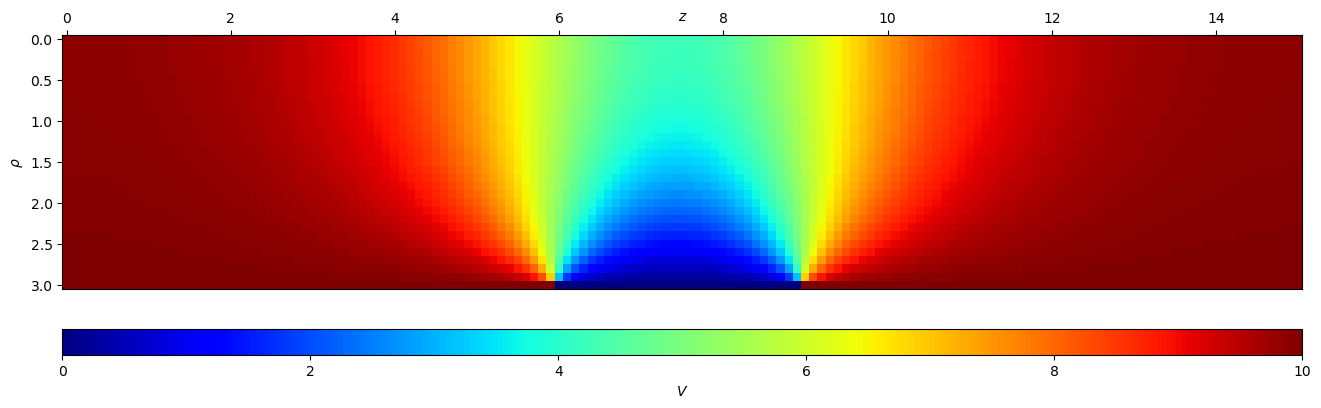

In [174]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
im = ax.matshow(V, origin="lower", cmap="jet")

# Tworzenie dodatkowej osi dla colorbara
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="10%", pad=0.4)

c = fig.colorbar(im, cax=cax, orientation='horizontal')
c.set_label("$V$")

ax.set_xlabel("$z$")
ax.set_ylabel(r'$\rho$')
ax.set_aspect('equal')

# Ustawienie oznaczeń osi x na dole
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_coords(0.5, 1.1)
ax.invert_yaxis()

# Modyfikacja skoku i etykiet osi x
xticks = ax.get_xticks()
ax.xaxis.set_major_locator(plt.FixedLocator(xticks))
ax.xaxis.set_major_formatter(plt.FixedFormatter(["{:.0f}".format(label / 10) for label in xticks]))


# Modyfikacja skoku i etykiet osi y
yticks = ax.get_yticks()
ax.yaxis.set_major_locator(plt.FixedLocator(yticks))
ax.yaxis.set_major_formatter(plt.FixedFormatter(["{:.1f}".format(label / 10) for label in yticks]))

plt.show()

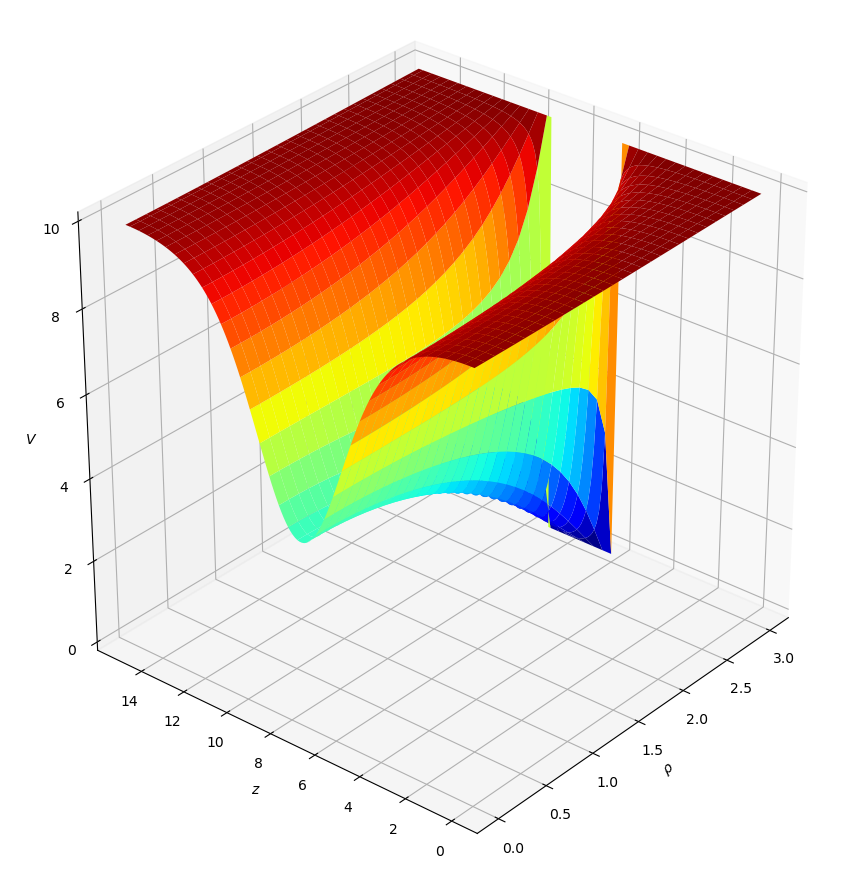

In [175]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection="3d")

Z, RHO = np.meshgrid(np.linspace(0, 15, M + 1), np.linspace(0, 3, N + 1))
surf = ax.plot_surface(RHO, Z, V, cmap="jet")

# Dostosowanie pozycji kamery
ax.view_init(elev=30, azim=220)
ax.set_box_aspect([1, 1, 1])  # Proporcje osi x, y, z są równe


ax.set_xlabel(r'$\rho$')
ax.set_ylabel("$z$")
ax.set_zlabel("$V$")

# Skalowanie aktualnych liczb na osiach
#def scale_func(x, factor):
#    return x * factor
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{scale_func(x, 3):.1f}"))
#ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{scale_func(x, 15):.1f}"))

plt.show()

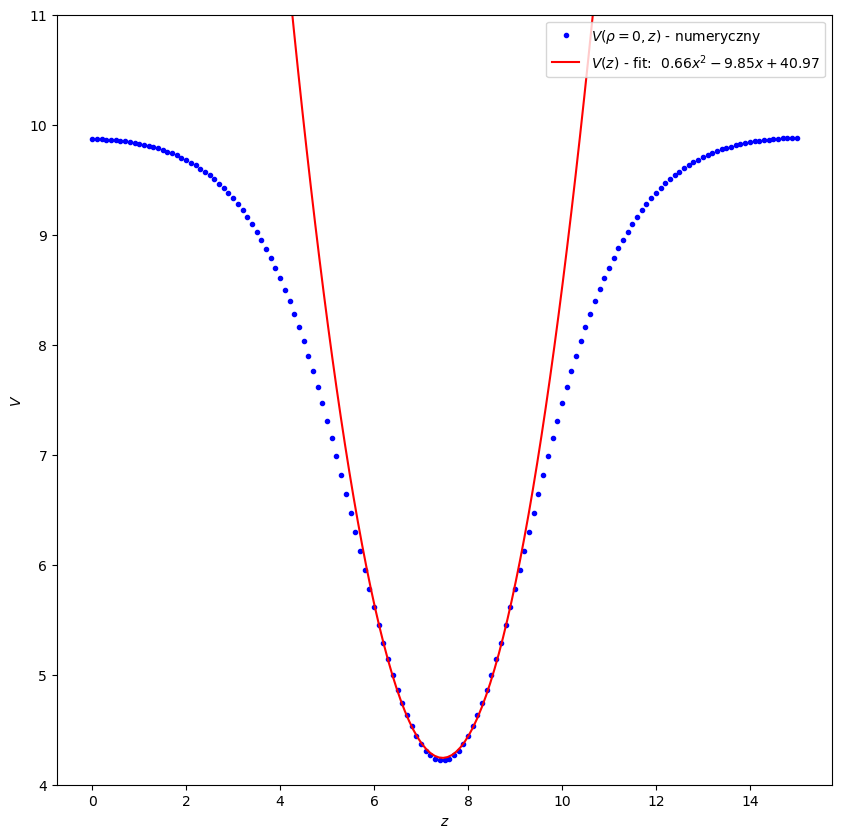

In [190]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# Wybór wartości dla rho = 0
Z_rho_0 = Z[0, :]
V_rho_0 = V[0, :]

ax.plot(Z_rho_0, V_rho_0, 'b.', label=r'$V(\rho=0,z)$ - numeryczny')
ax.set_xlabel('$z$')
ax.set_ylabel('$V$')

weights = np.ones_like(Z_rho_0)  # Domyślne wagi 1 dla wszystkich punktów

z_min = 6.2  # Dolny zakres z
z_max = 9.2  # Górny zakres z

mask = (Z_rho_0 >= z_min) & (Z_rho_0 <= z_max)

Z_fit = Z_rho_0[mask]
V_fit = V_rho_0[mask]

a, b, c, parabola_func = fit_parabola(Z_fit, V_fit, weights=weights[mask])
Z_plot = np.linspace(z_min-3, z_max+3, 100)
V_plot = parabola_func(Z_plot)
ax.set_ylim(4, 11)
ax.plot(Z_plot, V_plot, 'r-', label='$V(z)$ - fit:  ${}x^2 {}x + {}$'.format(round(a, 2), round(b, 2), round(c, 2)))
ax.legend(loc='upper right')
plt.show()

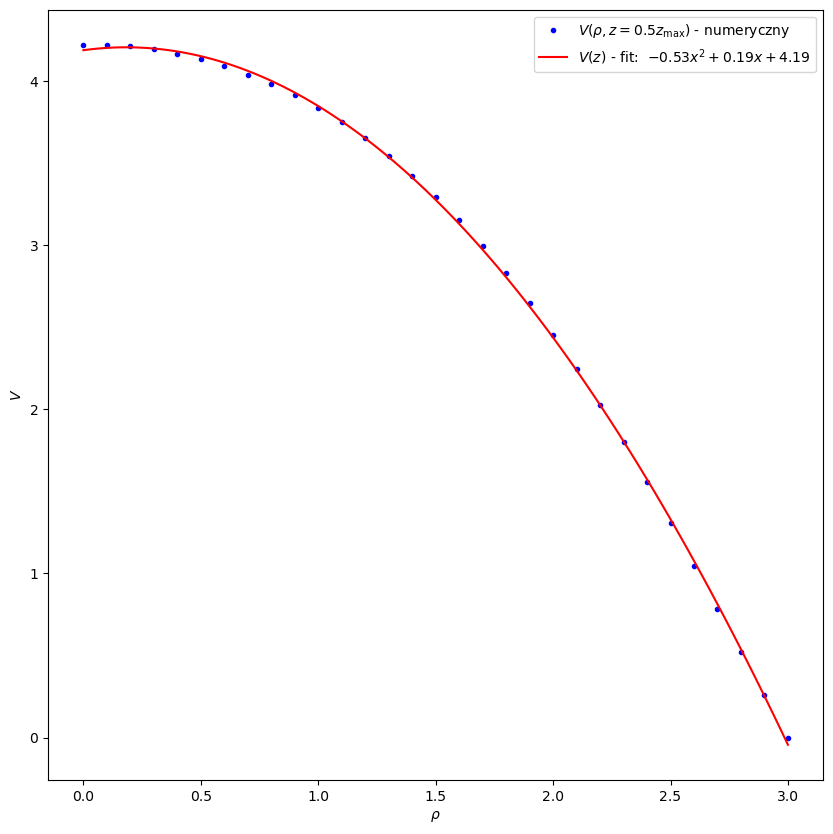

In [189]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Wybór wartości dla z = z_max/2
z_index = np.argmin(np.abs(Z[0, :] - Z.max()/2))
rho = RHO[:, z_index]
V_z_half = V[:, z_index]

ax.plot(rho, V_z_half, 'b.', label=r'$V(\rho,z=0.5z_{\max})$ - numeryczny')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('$V$')

a, b, c, parabola_func = fit_parabola(rho, V_z_half)
RHO_fit = np.linspace(min(rho), max(rho), 100)
V_fit = parabola_func(RHO_fit)
ax.plot(RHO_fit, V_fit, 'r-',label='$V(z)$ - fit:  ${}x^2 + {}x + {}$'.format(round(a, 2), round(b, 2), round(c, 2)))



ax.legend(loc='upper right')
plt.show()